[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/madoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Fetching news articles...
Number of articles after cleaning: 404

Visualizing data distribution...
source
Investing.com          31
GlobeNewswire          24
Yahoo Entertainment    17
The Times of India     13
Forbes                 13
                       ..
Cdm.link                1
WWD                     1
Socialnomics.net        1
Percona.com             1
Ironmarkusa.com         1
Name: count, Length: 203, dtype: int64
object


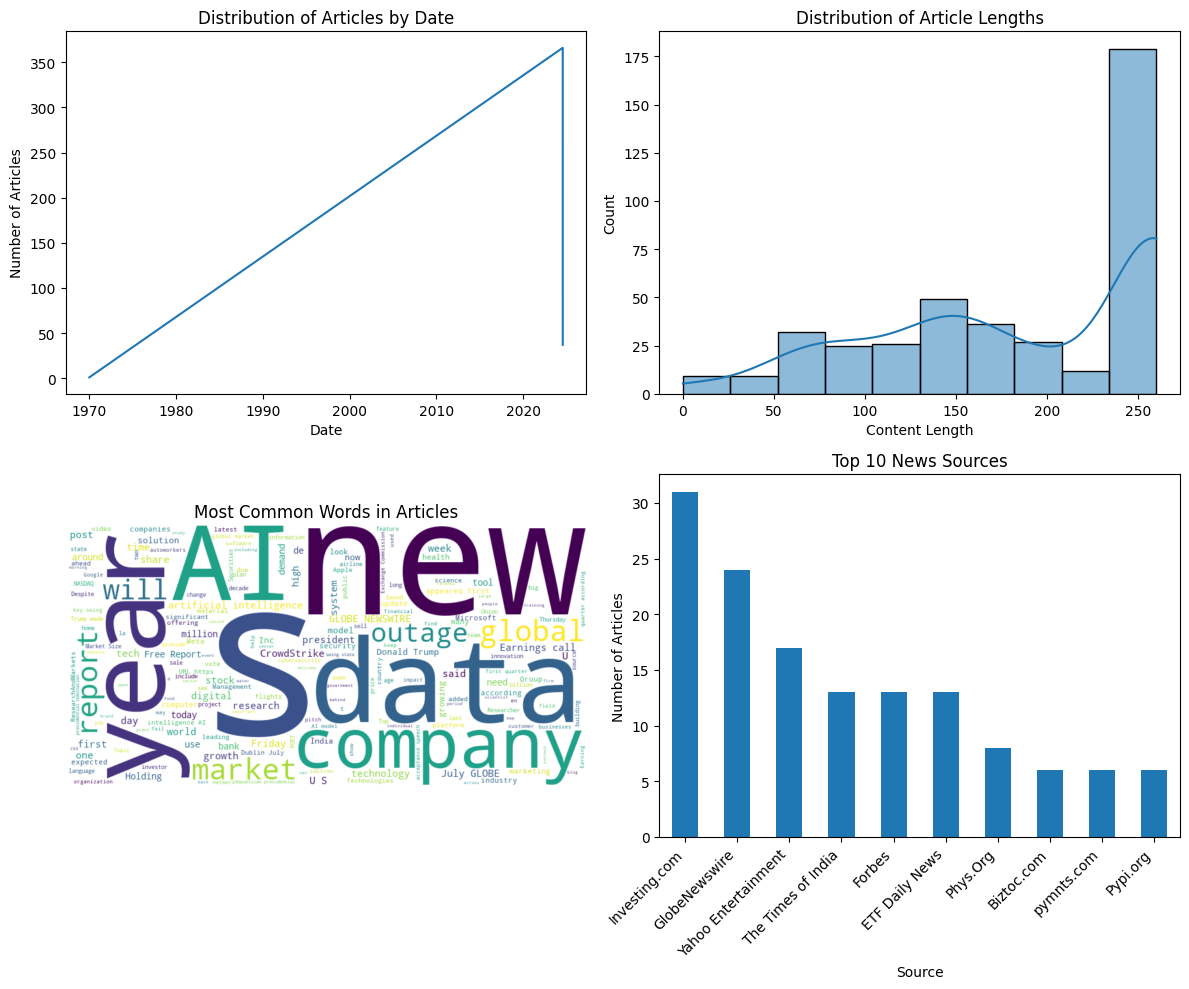


Performing K-means clustering...

Visualizing clusters...


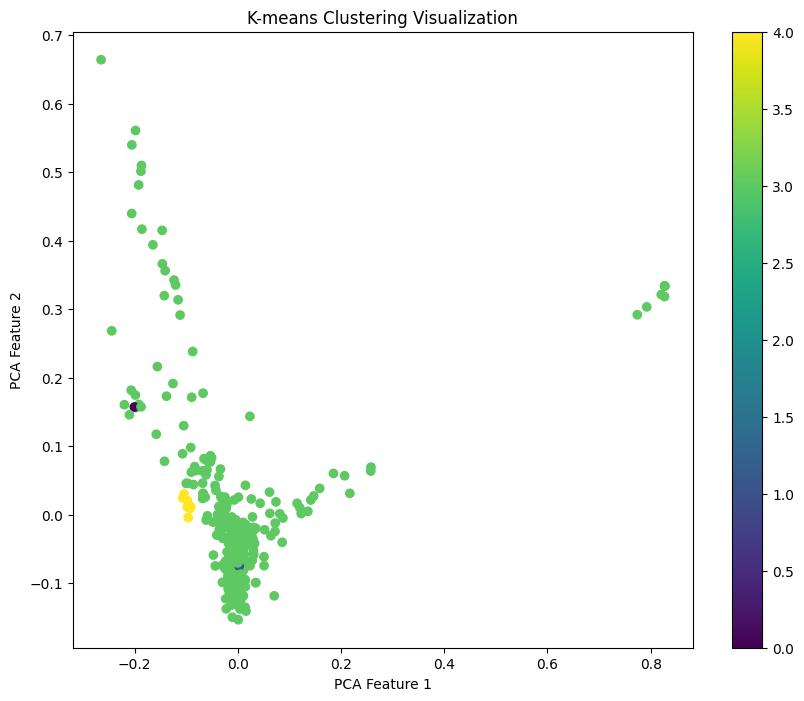


Analyzing cluster content...

Cluster 0:
Number of articles: 1

Top keywords:
embedded: 2
hypervisor: 2
software: 2
global: 2
report: 2
dublin: 1
july: 1
19: 1
2024: 1
globe: 1

Sample article titles:
- Embedded Hypervisor Software Industry Report 2023-2030: Increasing Adoption of Virtualization in Embedded Systems Throws the Spotlight on Hypervisor Software

Cluster 1:
Number of articles: 1

Top keywords:
past: 1
week: 1
two: 1
companies: 1
revealed: 1
targets: 1
massive: 1
cyberattacks: 1
based: 1
investigation: 1

Sample article titles:
- The Small Cybersecurity Company Winning Big in the Cybersecurity Space

Cluster 2:
Number of articles: 1

Top keywords:
training: 1
systems: 1
help: 1
learners: 1
second: 1
language: 1
improve: 1
pronunciation: 1
skills: 1

Sample article titles:
- Automatic Pronunciation Assessment Systems for English Students from Argentina

Cluster 3:
Number of articles: 394

Top keywords:
2024: 50
data: 44
ai: 43
market: 42
new: 41
global: 39
july: 30
intellig

In [4]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# 1. 必要なNLTKデータのダウンロードgit 
nltk.download('stopwords')
nltk.download('punkt')

# 2. ニュース記事を取得する関数
def fetch_news(keyword, page=1):
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": keyword,
        "apiKey": "2ef5ed8eca2e4c76b0cfd43410b4b332",
        "sortBy": "publishedAt",
        "pageSize": 100,
        "page": page
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # HTTPエラーチェック
        return response.json().get("articles", [])
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"An error occurred: {err}")
    return []

# 3. 複数のキーワードでニュース記事を取得
def fetch_all_news():
    keywords = ["data science", "machine learning", "artificial intelligence", "big data", "data analytics"]
    all_articles = []
    for keyword in keywords:
        articles = fetch_news(keyword)
        all_articles.extend(articles)
    return all_articles

# 4. データのクリーニングと前処理
def clean_data(articles):
    df = pd.DataFrame(articles)
    df = df.drop_duplicates(subset=['title', 'url'])  # 重複記事の削除
    df['description'] = df['description'].fillna('')  # 欠損値の処理
    df['source'] = df['source'].apply(lambda x: x['name'] if isinstance(x, dict) else x)  # sourceの処理
    return df

# 5. データの分布を視覚化
def visualize_data_distribution(df):
    print(df['source'].value_counts())
    print(df['source'].dtype)
    plt.figure(figsize=(12, 10))
    
    # 1. 記事の出版日の分布
    plt.subplot(2, 2, 1)
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df['publishedAt'].dt.date.value_counts().sort_index().plot(kind='line')
    plt.title('Distribution of Articles by Date')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    
    # 2. 記事の長さの分布
    plt.subplot(2, 2, 2)
    df['content_length'] = df['description'].str.len()
    sns.histplot(df['content_length'], kde=True)
    plt.title('Distribution of Article Lengths')
    plt.xlabel('Content Length')
    
    # 3. 最も頻出する単語のワードクラウド
    plt.subplot(2, 2, 3)
    all_text = ' '.join(df['description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in Articles')   
    
    # 4. ソース（出版社）の分布
    plt.subplot(2, 2, 4)
    df['source'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 News Sources')
    plt.xlabel('Source')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# 6. テキストから重要な単語を抽出
def get_important_words(text, n=10):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text.lower())
    important_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]
    return Counter(important_words).most_common(n)

# 7. K-meansクラスタリングの実行
def perform_kmeans_clustering(df, n_clusters=5):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['description'])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(tfidf_matrix)
    
    return kmeans_labels, tfidf_matrix, vectorizer

# 8. クラスターの可視化
def visualize_clusters(tfidf_matrix, labels):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('K-means Clustering Visualization')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.show()

# 9. クラスター内容の分析
def analyze_cluster_content(df, labels, tfidf_matrix, vectorizer):
    df['Cluster'] = labels
    for cluster in set(labels):
        cluster_articles = df[df['Cluster'] == cluster]
        print(f"\nCluster {cluster}:")
        print(f"Number of articles: {len(cluster_articles)}")
        
        cluster_text = ' '.join(cluster_articles['description'])
        print("\nTop keywords:")
        for word, count in get_important_words(cluster_text):
            print(f"{word}: {count}")
        
        print("\nSample article titles:")
        for title in cluster_articles['title'].sample(min(5, len(cluster_articles))):
            print(f"- {title}")

# 10. メイン関数：全体の処理フローを制御
def main():
    print("Fetching news articles...")
    articles = fetch_all_news()
    
    if articles:
        df = clean_data(articles)
        print(f"Number of articles after cleaning: {len(df)}")
        
        print("\nVisualizing data distribution...")
        visualize_data_distribution(df)
        
        print("\nPerforming K-means clustering...")
        kmeans_labels, tfidf_matrix, vectorizer = perform_kmeans_clustering(df)
        
        print("\nVisualizing clusters...")
        visualize_clusters(tfidf_matrix, kmeans_labels)
        
        print("\nAnalyzing cluster content...")
        analyze_cluster_content(df, kmeans_labels, tfidf_matrix, vectorizer)
        
        print(f"\nTotal articles fetched and analyzed: {len(df)}")
    else:
        print("No articles were fetched.")

if __name__ == "__main__":
    main()